# Imports

In [18]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Reading the Data

We read the data and see that the training data has over four thousand rows and thirty three features.

Insight: 

1. Avoid algorithm that suffers from the curse of dimensionality(KNN, etc)
2. At some point we will need to use dimensionality reduction technique(PCA, t-SNE) or remove useless features.

In [2]:
train_data = pd.read_csv('../data/train_test_data/train.csv')
test_data = pd.read_csv('../data/train_test_data/test.csv')

train_data.shape

(4120, 34)

In [3]:
train_data.head()

,Unnamed: 0,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,...,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,1176,2022-12-28,1.0,27.323000,14.823000,20.573002,25.777689,14.690771,19.505260,0,...,10.4179,32.275000,324.541667,1.706250,1.164583,90.208333,0.277083,9.916667,2.185417,2.189583
1,4770,2022-12-17,1.0,29.528000,17.528000,23.321753,32.480470,18.525795,24.953913,0,...,13.6833,12.837500,312.500000,0.118750,0.231250,57.791667,0.343333,2.958333,1.581250,1.979167
2,1090,2022-10-03,65.0,23.773000,15.323000,18.233418,24.630080,16.138641,19.608873,0,...,10.4179,20.445833,232.000000,1.827083,0.347917,54.416667,0.249167,16.625000,1.970833,2.566667
3,4817,2023-02-02,1.0,32.478000,19.227999,25.419668,35.235100,21.212915,27.534365,0,...,13.6833,30.583333,381.375000,0.358333,0.491667,53.958333,0.446667,3.333333,2.075000,2.218750
4,4375,2023-04-16,3.0,39.858498,28.508501,33.854332,42.387520,30.281784,35.202442,0,...,13.4000,38.733333,307.833333,1.429167,0.454167,61.500000,0.697500,74.916667,1.783333,2.170833


In [4]:
train_data.drop('Unnamed: 0', axis = 1, inplace = True)
test_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [6]:
train_data.duplicated().sum().sum(), test_data.duplicated().sum().sum()

(0, 0)

No null values, no duplicates, the dataset appear to be relatively clean.

# Target Distribution

The target distribution appear to be skewed to the right, this indicates the presence of outliers.The highest value for pm2_5 is 172.8291 for the city of Bertoua.

/home/maxtheking/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

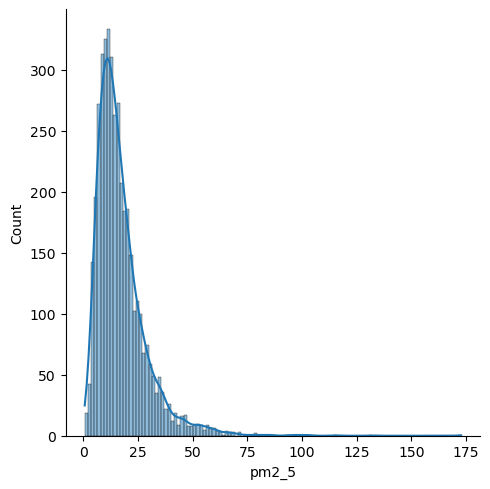

In [7]:

plt.figure(figsize = (12, 6))
sns.displot(train_data['pm2_5'], kde = True)
plt.show()

We can understand a little bit more the overall air quality by creating categories: 

- Good: pm2_5 < 12.5
- Fair: pm2_5 [12.5–25]
- Poor: pm2_5 	[25–50]
- Very poor: pm2_5 [50–150]
- Extremely poor: pm2_5 More than 150


/home/maxtheking/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='category', ylabel='Count'>

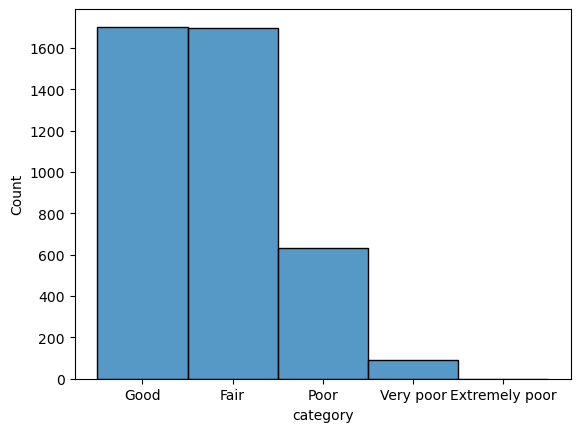

In [8]:
train_data['category'] = pd.cut(train_data['pm2_5'], 
                        bins=[-float('inf'), 12.5, 25, 50, 150, float('inf')], 
                        labels=['Good', 'Fair', 'Poor', 'Very poor', 'Extremely poor'])

sns.histplot(train_data['category'])

The vast majority of sample fall under the Good and Fair category, meaning that the air quality is usually of that quality in Cameroon.

In [9]:
train_data.groupby('city')['pm2_5'].mean()

city
Bafoussam     21.769081
Bamenda       20.146944
Bertoua       17.205552
Buea          13.955294
Douala        16.375233
Ebolowa       10.882733
Garoua        21.008722
Maroua        18.974740
Ngaoundéré    14.738632
Yaoundé       16.215085
Name: pm2_5, dtype: float64

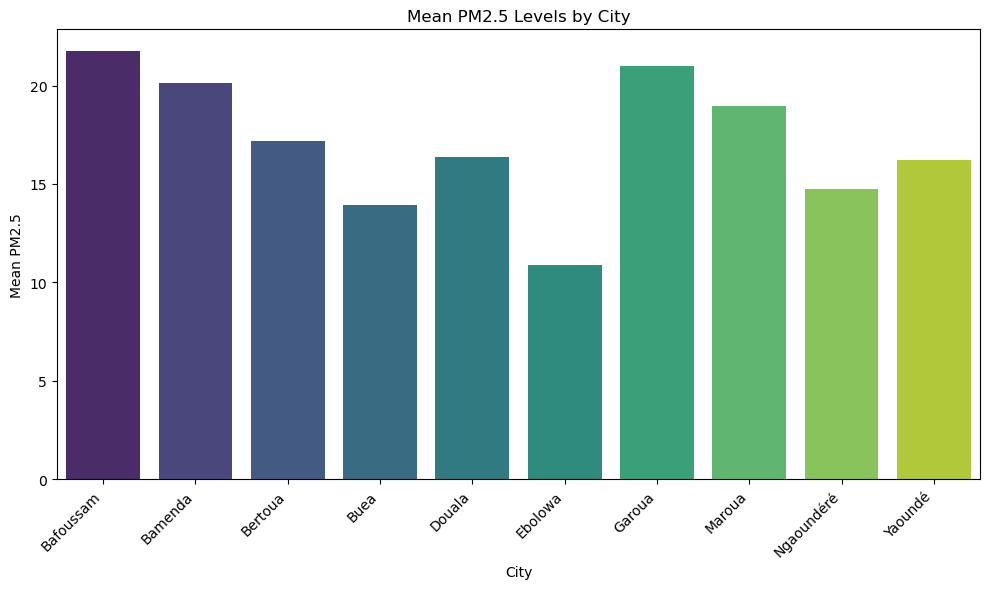

In [10]:
mean_pm2_5_by_city = train_data.groupby('city')['pm2_5'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='pm2_5', data=mean_pm2_5_by_city, palette='viridis')
plt.title('Mean PM2.5 Levels by City')
plt.xlabel('City')
plt.ylabel('Mean PM2.5')
plt.xticks(rotation=45, ha='right')  # Rotate city names for better readability
plt.tight_layout()

# Show the plot
plt.show()

On average the air quality amongs the different cities in Cameroon is fair.

Features like sunrise, sunset, snowfall_sum are non existent in a country like Cameroon, that's why all the values for these features are 0. They are constant so we can delete them

In [11]:
train_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)
test_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)

# Feature Distribution

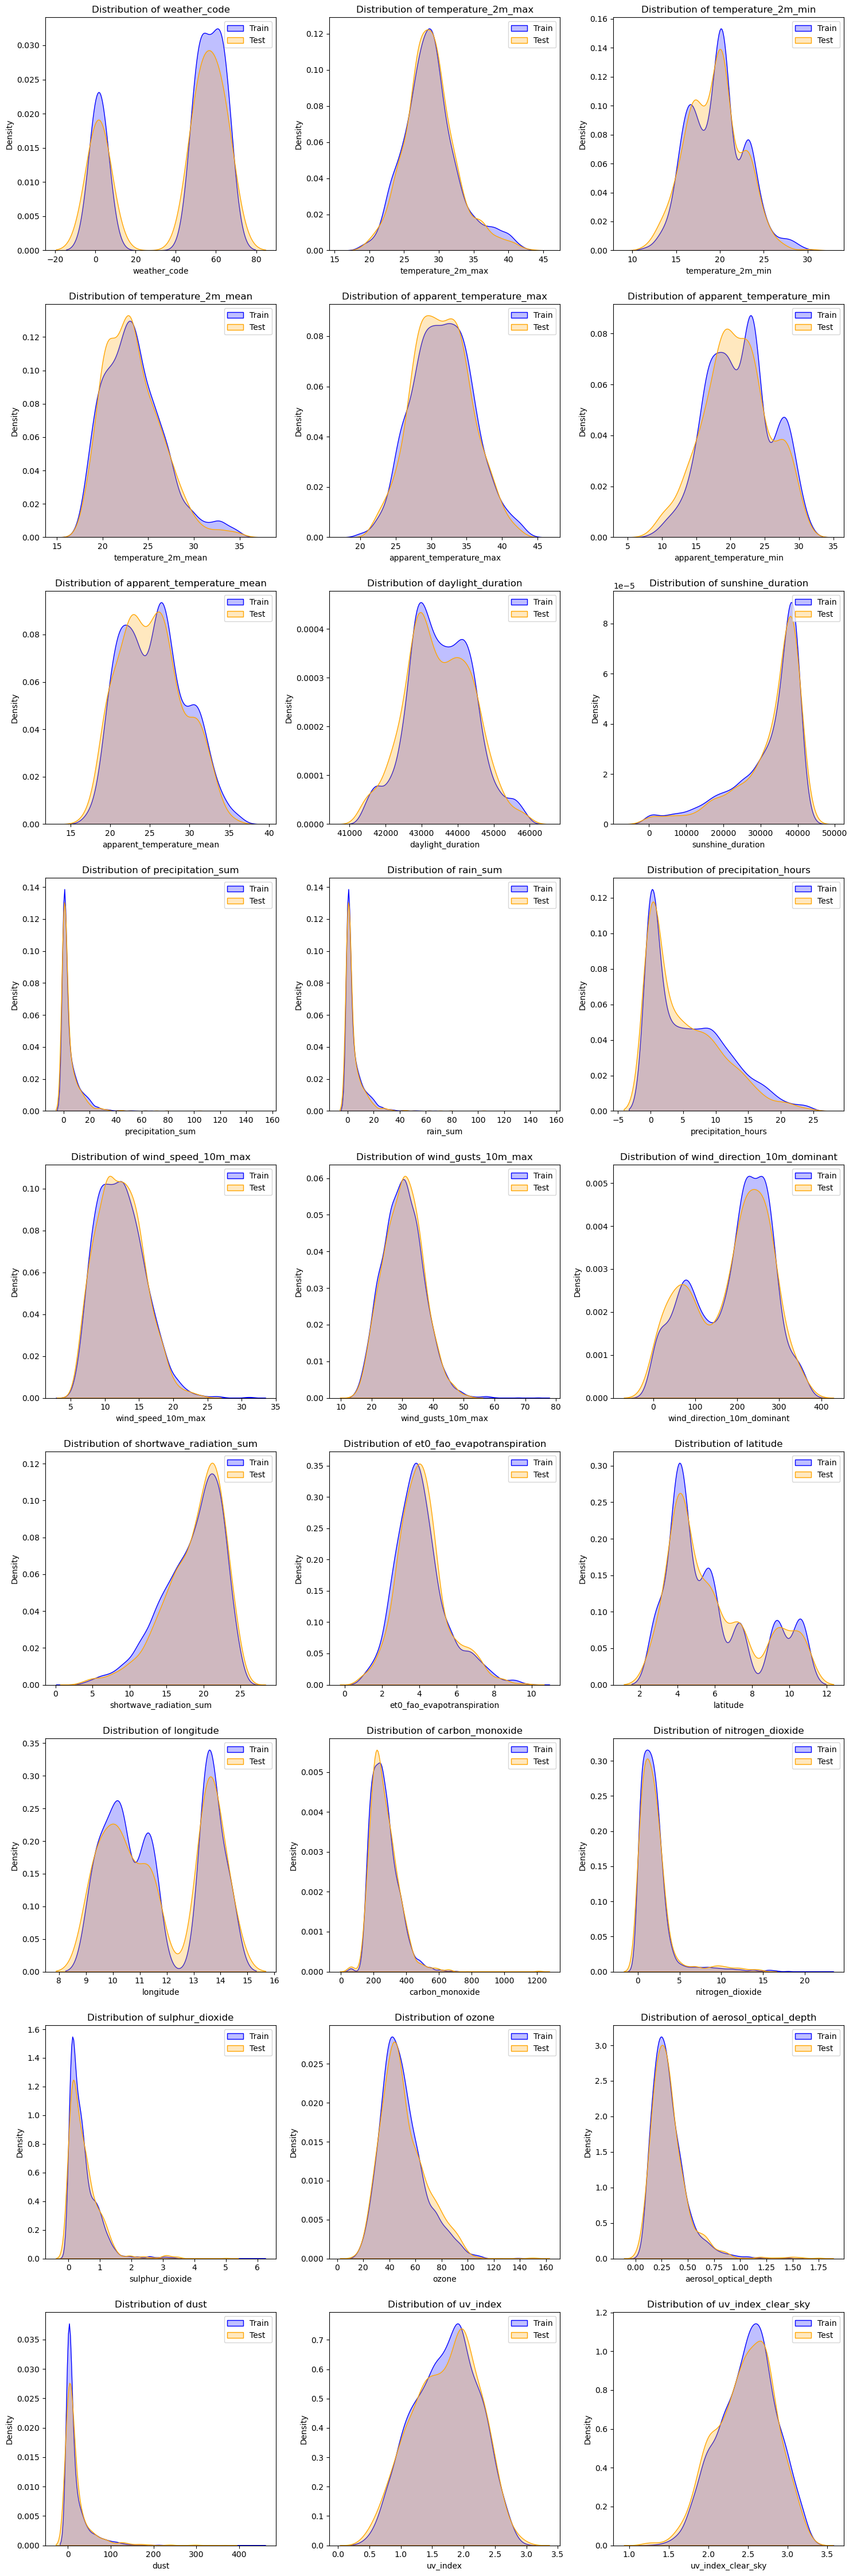

In [20]:
# Create a figure with subplots for each feature
features = list(test_data.select_dtypes(['Int64', 'float64'])) # List of all features in your dataset
n_features = len(features)  # Number of features to plot

# Number of columns per row (3 features per row)
n_cols = 3
# Number of rows, calculated by dividing the total features by the number of columns
n_rows = math.ceil(n_features / n_cols)

# Set up the figure with subplots (n_rows x n_cols grid)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size

# Flatten the axes array for easy iteration, if needed
axes = axes.flatten()

# Iterate through each feature and plot its distribution for train and test sets
for i, feature in enumerate(features):
    ax = axes[i]
    
    # Plot the distribution of the feature in the train set
    sns.kdeplot(train_data[feature], ax=ax, label='Train', color='blue', fill=True)
    
    # Plot the distribution of the feature in the test set
    sns.kdeplot(test_data[feature], ax=ax, label='Test', color='orange', fill=True)
    
    # Set plot labels and title
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Remove any empty subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

The distribution of data in the train and test set appear to be relatively the same. We observe that some features are right and left skewed distributed. We can use log transformation to deal with that.

# Correlations

<Axes: >

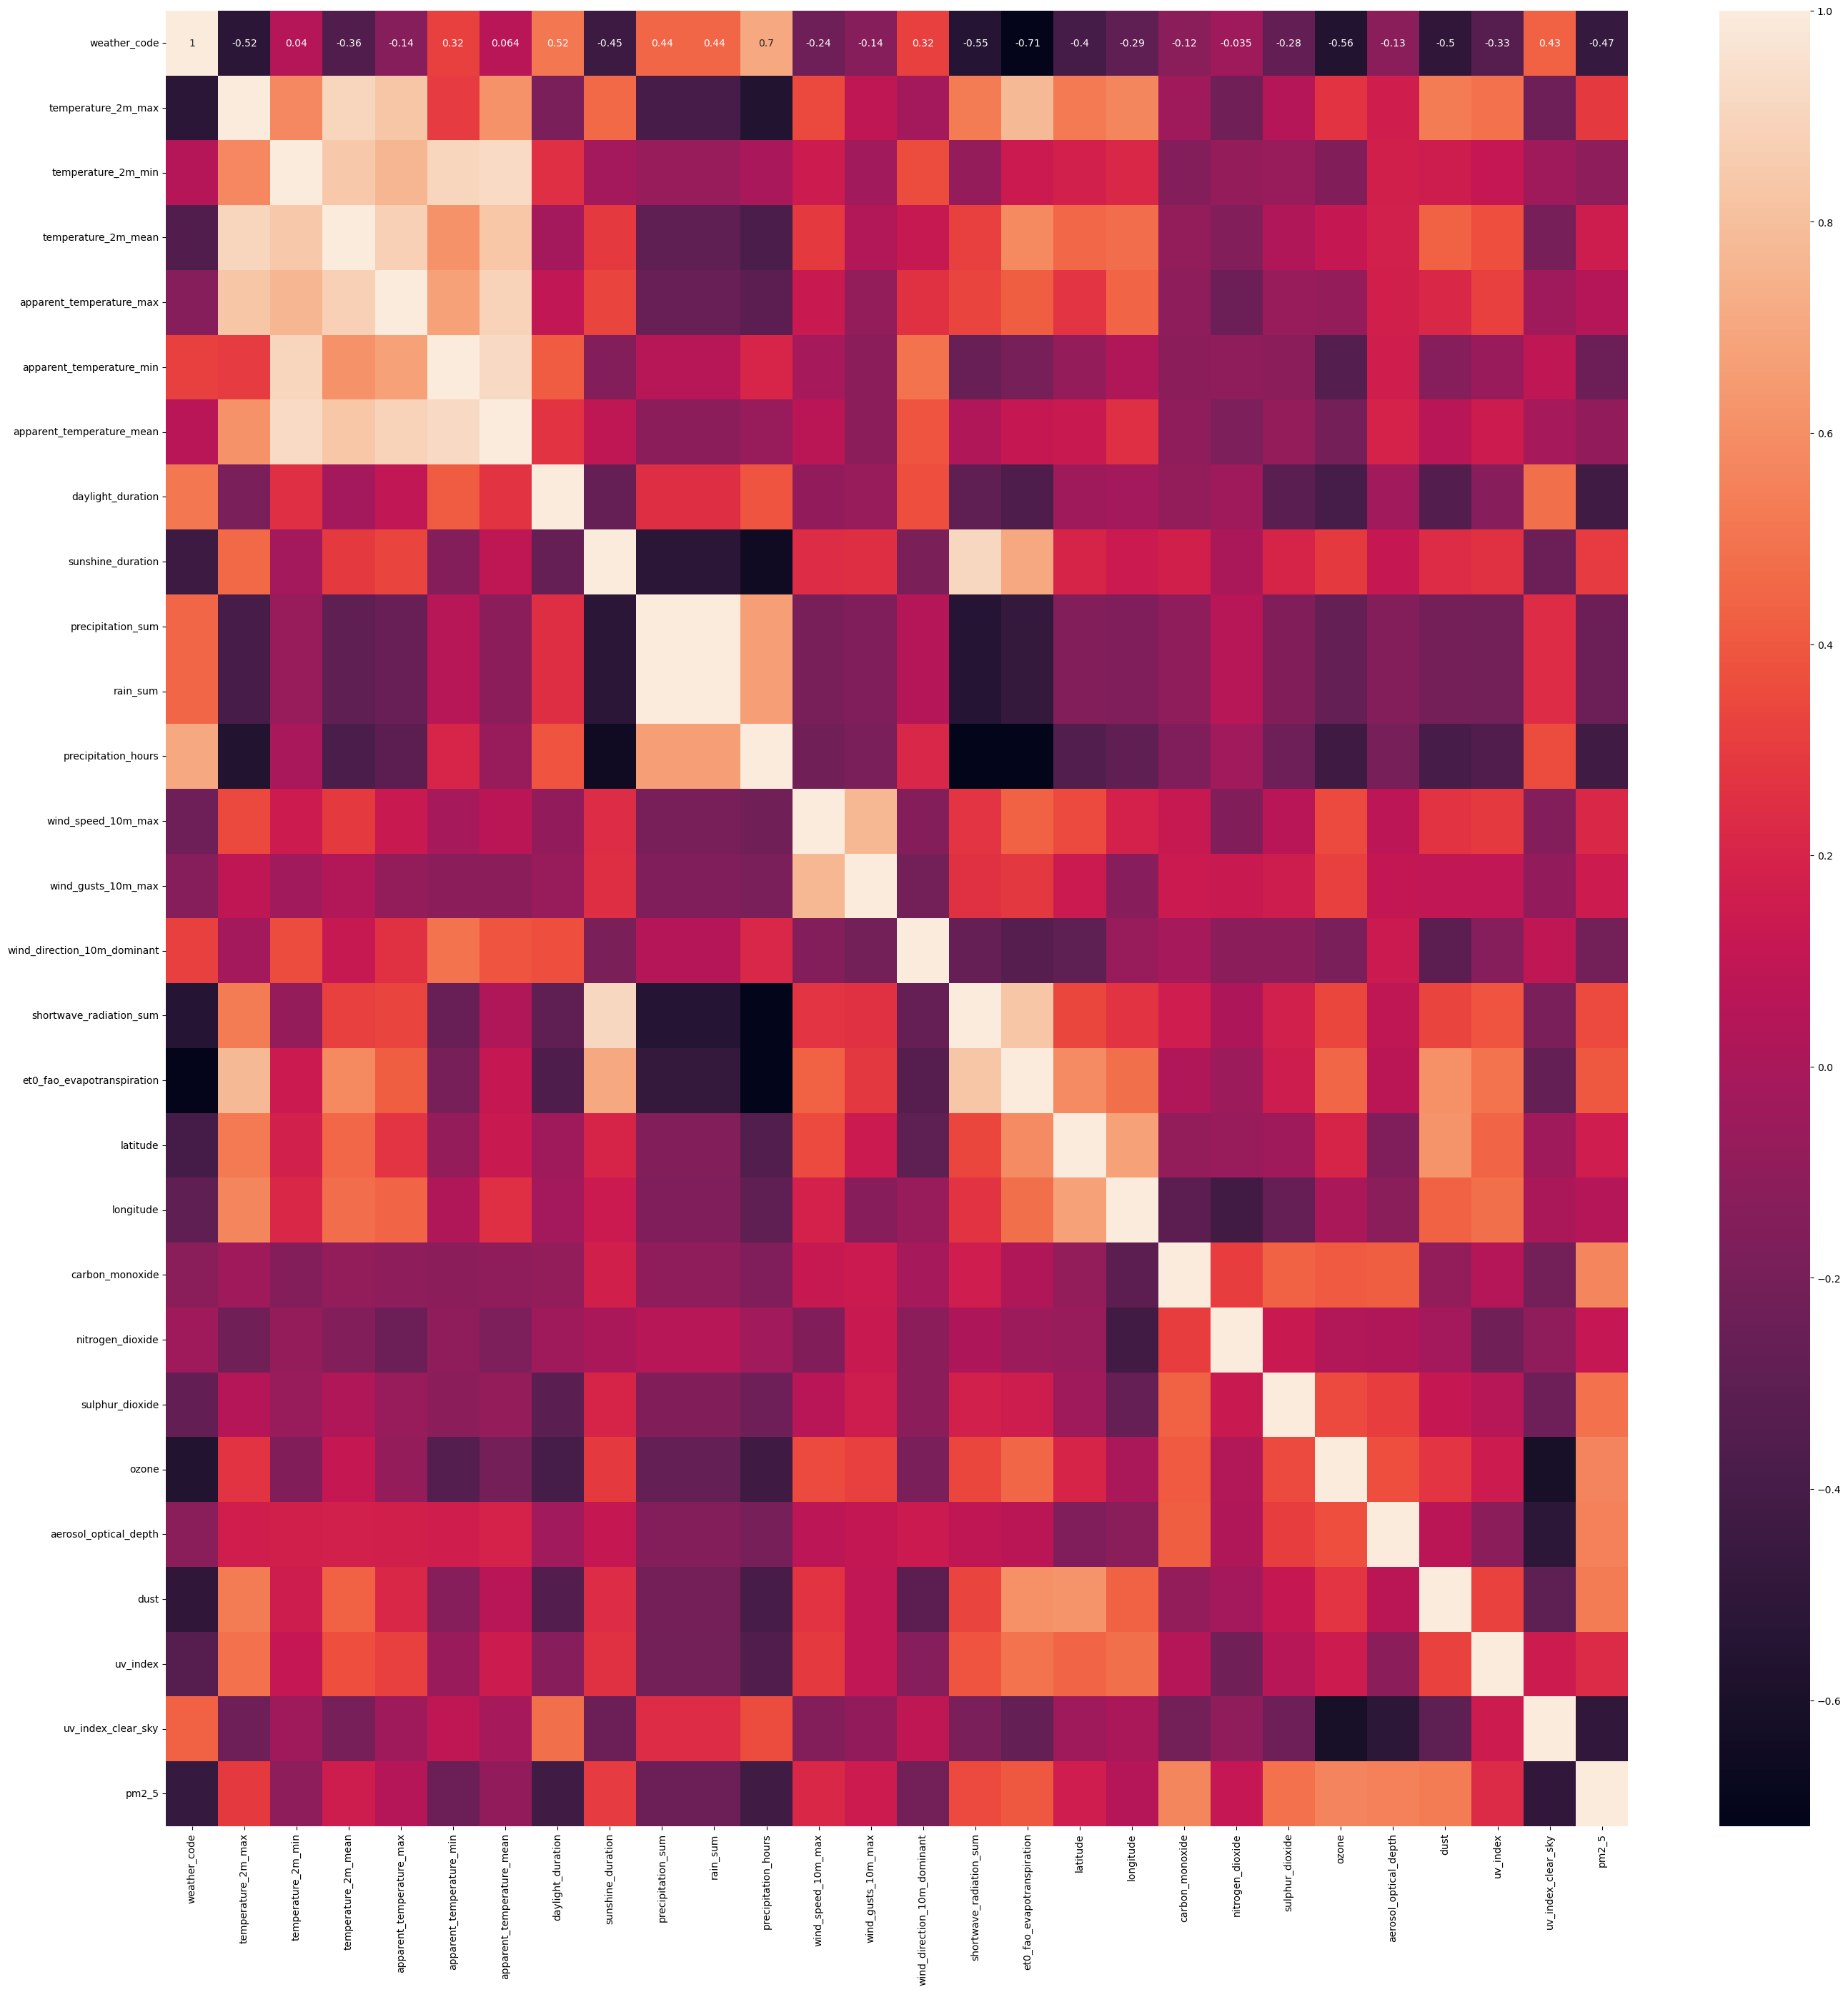

In [34]:
plt.figure(figsize = (33, 33))
sns.heatmap(train_data[features + ['pm2_5']].corr(), annot = True)

#train_data[features + ['pm2_5']].corr()['dust'].sort_values(ascending = False)

The correlation heatmap is unusable because there are too many features to visualize. We need to find a better way to see how our features interact with each other.

# Dimensionality Reduction